# Comparing synthetic turbulence

In [1]:
%%capture

# Change some display properties
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

# Important header information

# Import libraries
import sys
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset

naluhelperdir = '../utilities'
sys.path.insert(1, naluhelperdir)
import windspectra
#import yaml as yaml
#from IPython.display import Image
from matplotlib.lines import Line2D
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
cases=[['AMR wenoz',   'amrwind_wenoz',   {'ls':'--', 'color':'r'}],
       ['AMR ppmnolim','amrwind_ppmnolim',{'ls':'-.', 'color':'pink'}],
       ['NALU upwind', 'naluwind_upwind', {'ls':'-', 'color':'b'}]
      ]

#colorcycle=['b', 'g', 'r', 'c', 'm', 'y', 'k']

## Load the Mann box 

In [3]:
# Get the timei vector
Uavg = 10.0
# Set the scaling factors
ds=5.0
eps=2.5 #2*ds
gaussScale = 1 #np.sqrt(1.0/(eps*np.sqrt(np.pi)*ds))

filename='../mann_turb/turbulence.nc'
ncbox={}
with Dataset(filename) as d:
    #print(d.variables)
    ncbox['ndim'] = d.dimensions['ndim'].size
    ncbox['nx']   = d.dimensions['nx'].size
    ncbox['ny']   = d.dimensions['ny'].size
    ncbox['nz']   = d.dimensions['nz'].size
    ncbox['L']    = d.variables['box_lengths'][:]
    ncbox['dx']   = d.variables['dx'][:]
    ncbox['uvel'] = d.variables['uvel'][:,:,:]
    ncbox['vvel'] = d.variables['vvel'][:,:,:]
    ncbox['wvel'] = d.variables['wvel'][:,:,:]
    tvec = ncbox['dx'][0]/Uavg*np.arange(ncbox['nx'])

In [4]:
# Average over the entire inlet plane of turbulence
Suu = []
Svv = []
Sww = []
itotal = 0
print("Working...")
for i in range(ncbox['ny']):
    sys.stdout.write("\r%d%%" % int(i*100.0/ncbox['ny']))
    sys.stdout.flush()
    for j in range(ncbox['nz']):
        f, tSuu = windspectra.getWindSpectra(tvec, ncbox['uvel'][:,i,j]*gaussScale)
        f, tSvv = windspectra.getWindSpectra(tvec, ncbox['vvel'][:,i,j]*gaussScale)
        f, tSww = windspectra.getWindSpectra(tvec, ncbox['wvel'][:,i,j]*gaussScale)
        Suu = tSuu if len(Suu) == 0 else Suu + tSuu
        Svv = tSuu if len(Svv) == 0 else Svv + tSvv
        Sww = tSuu if len(Sww) == 0 else Sww + tSww
        itotal += 1
Suu = Suu/float(itotal)
Svv = Svv/float(itotal)
Sww = Sww/float(itotal)
print("")
print("Done.")

# Octave band average 
Nband=3
Mannf, MannSuu = windspectra.NarrowToOctaveBand(f, Suu, Nband)
Mannf, MannSvv = windspectra.NarrowToOctaveBand(f, Svv, Nband)
Mannf, MannSww = windspectra.NarrowToOctaveBand(f, Sww, Nband)

Working...
99%
Done.


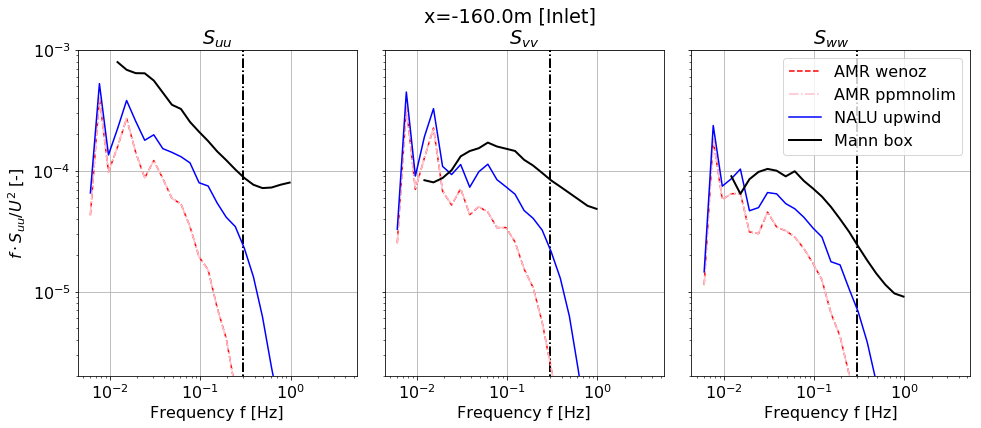

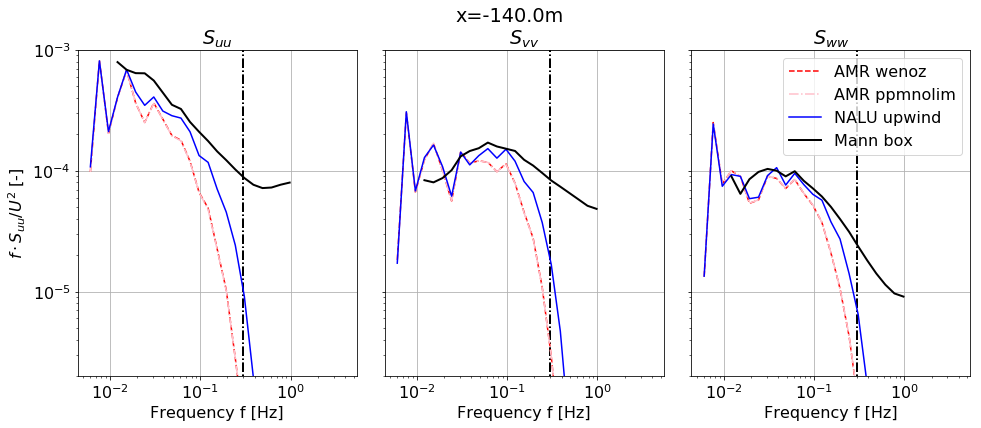

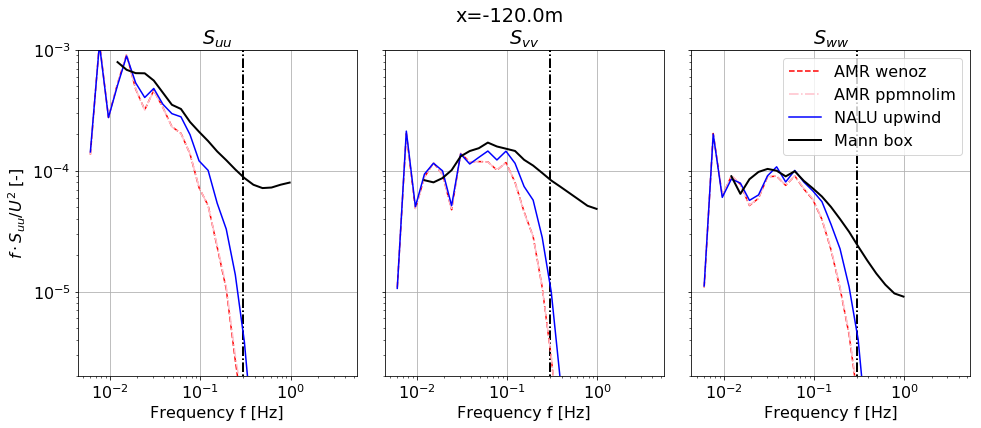

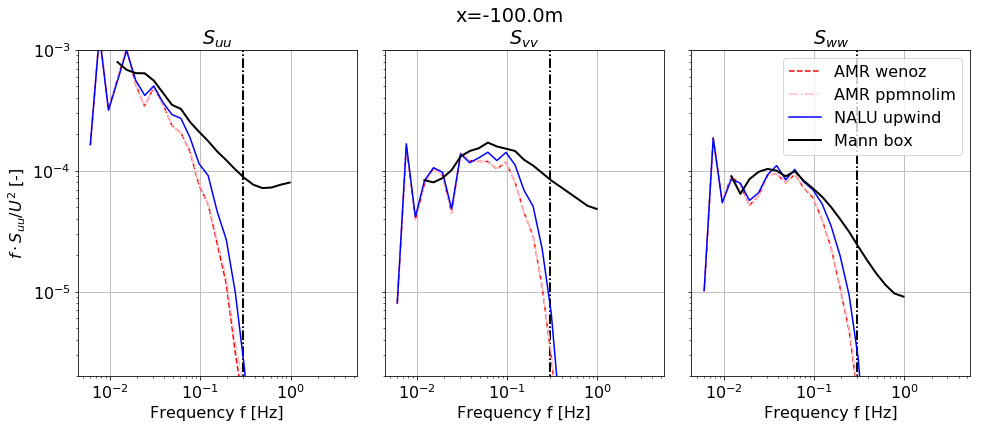

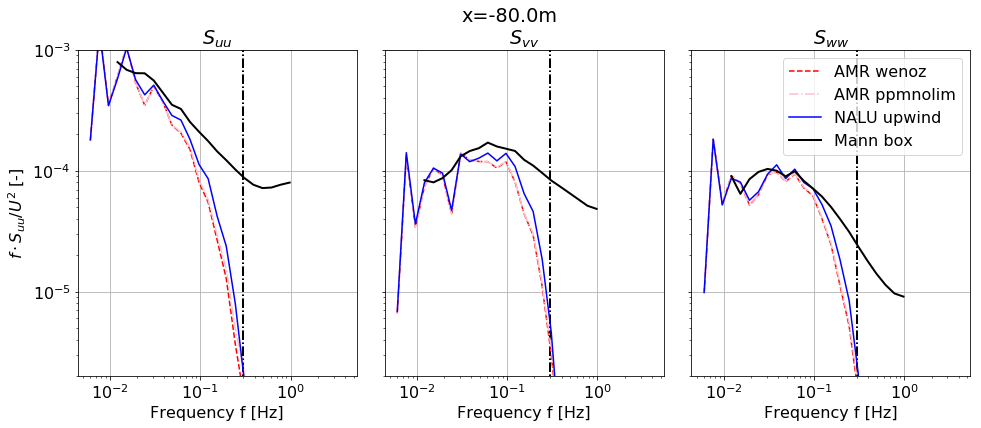

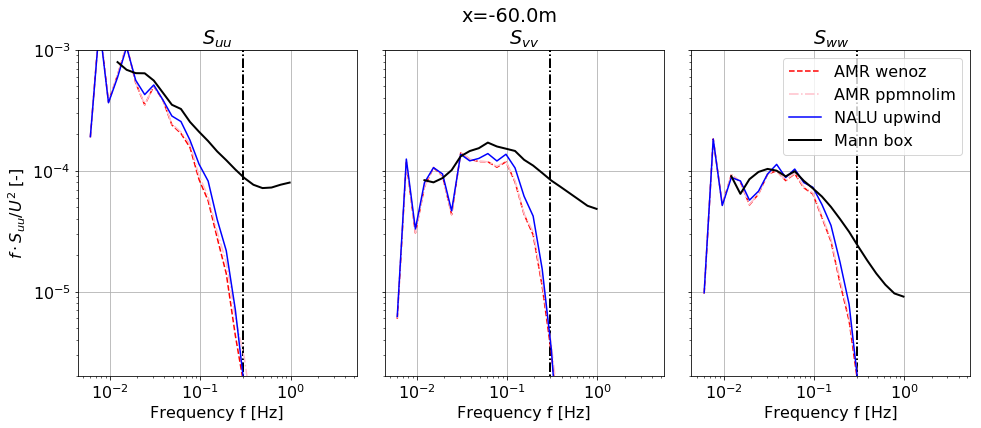

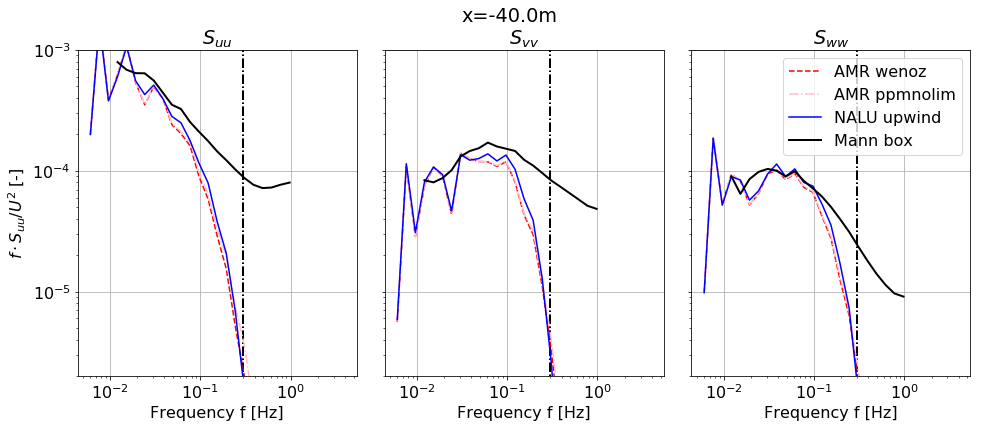

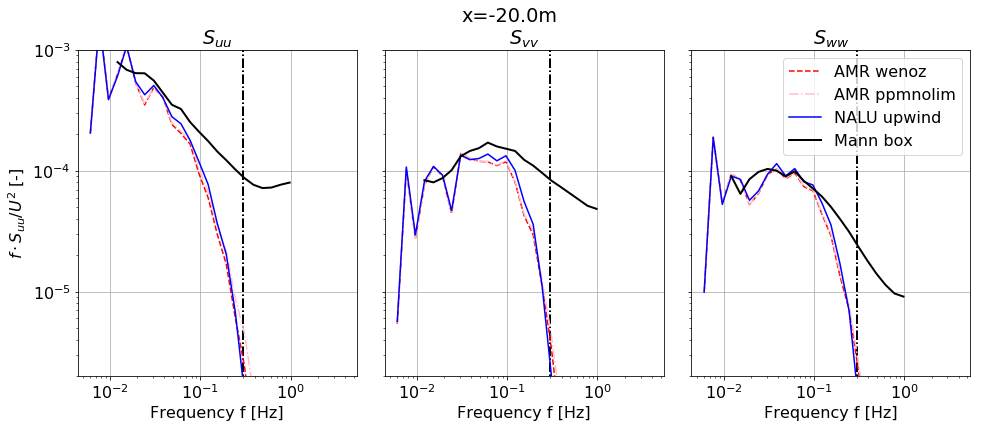

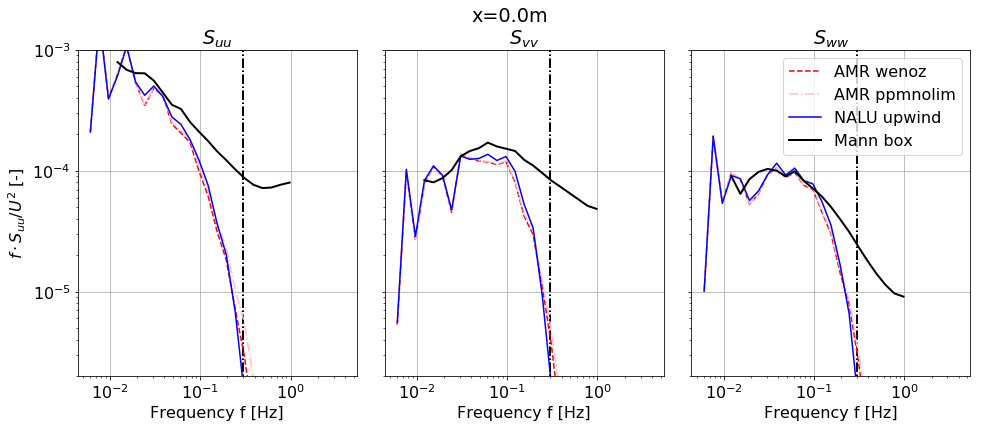

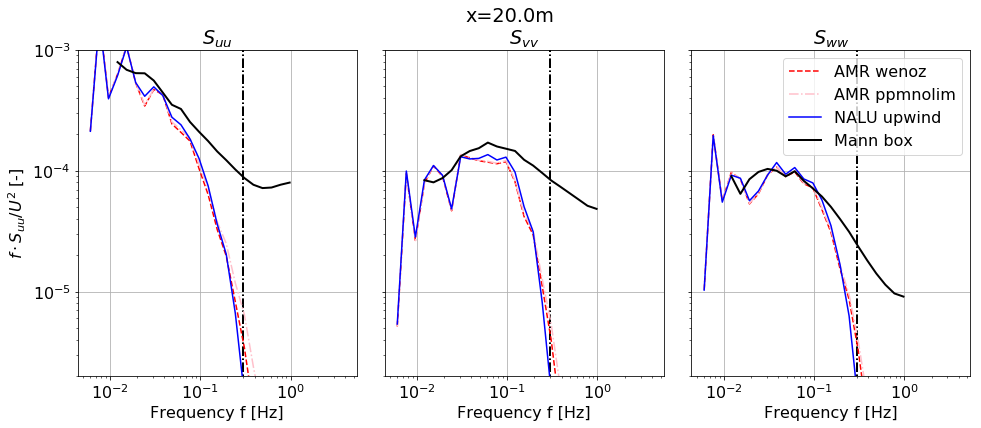

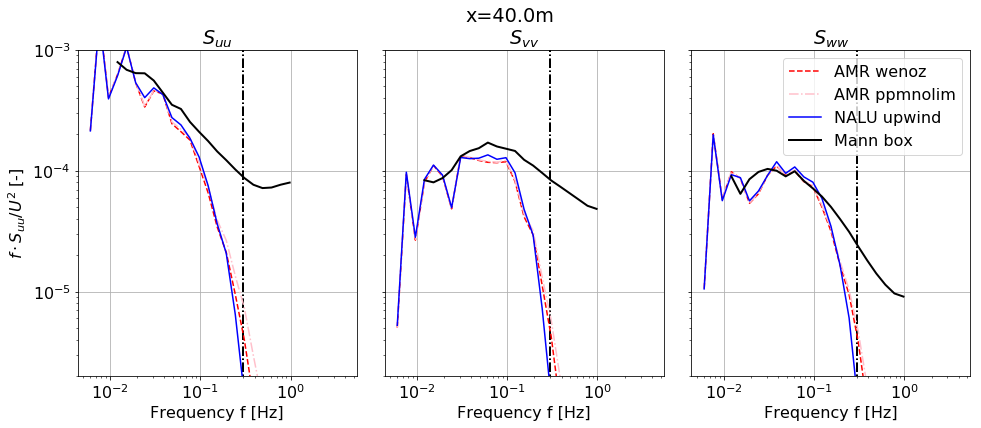

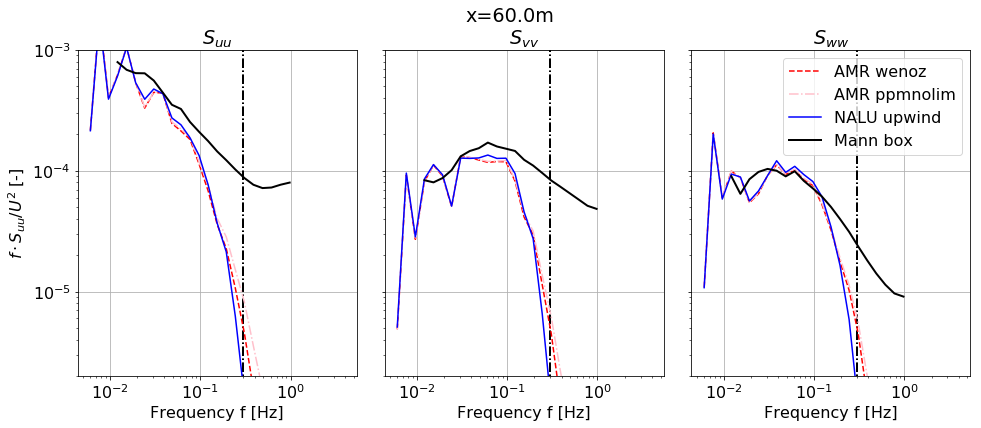

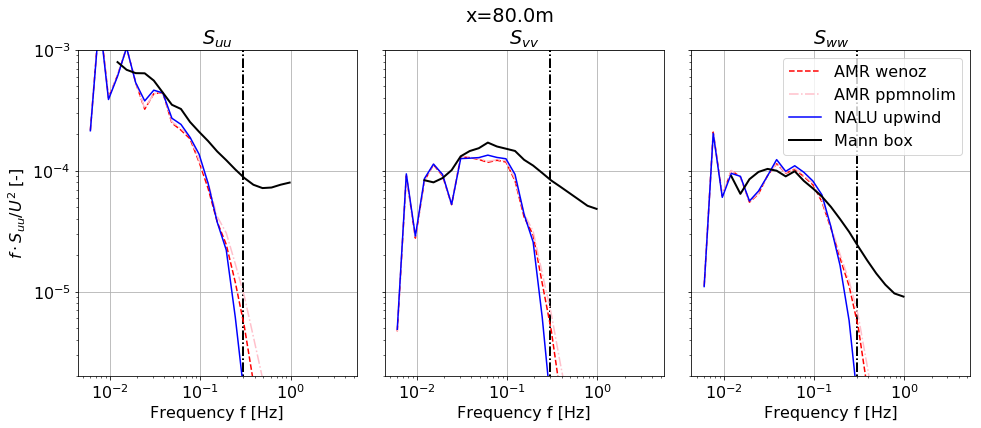

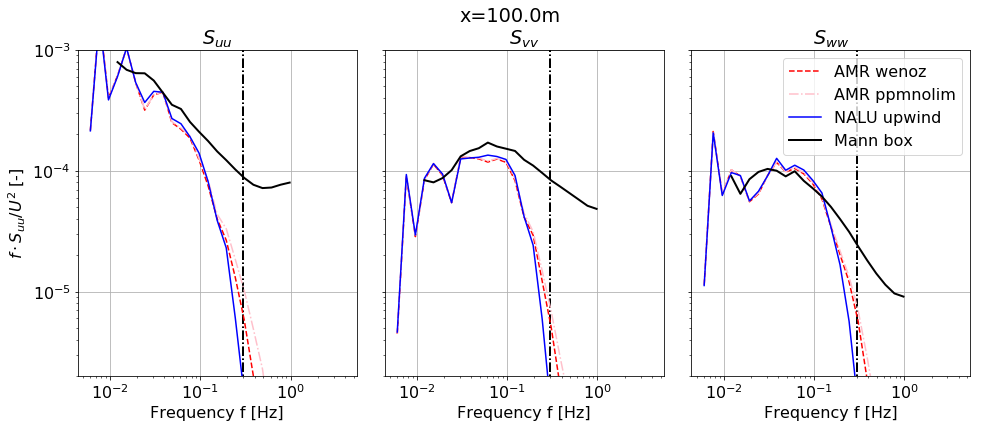

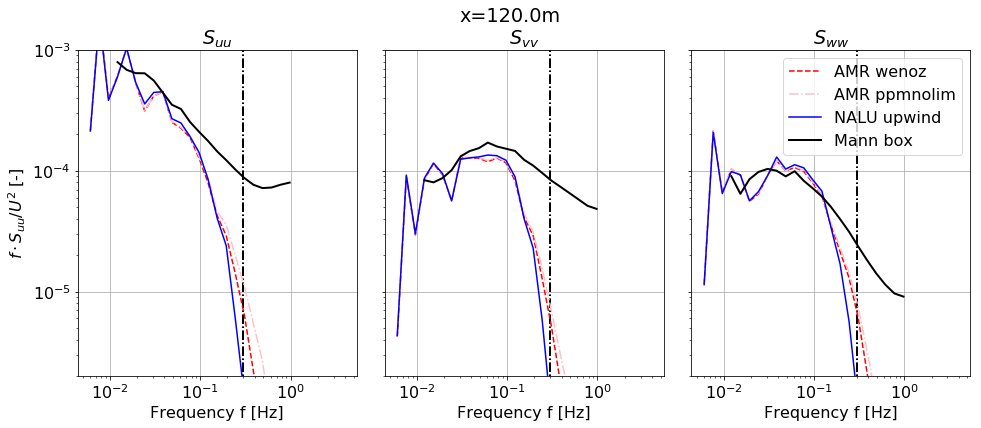

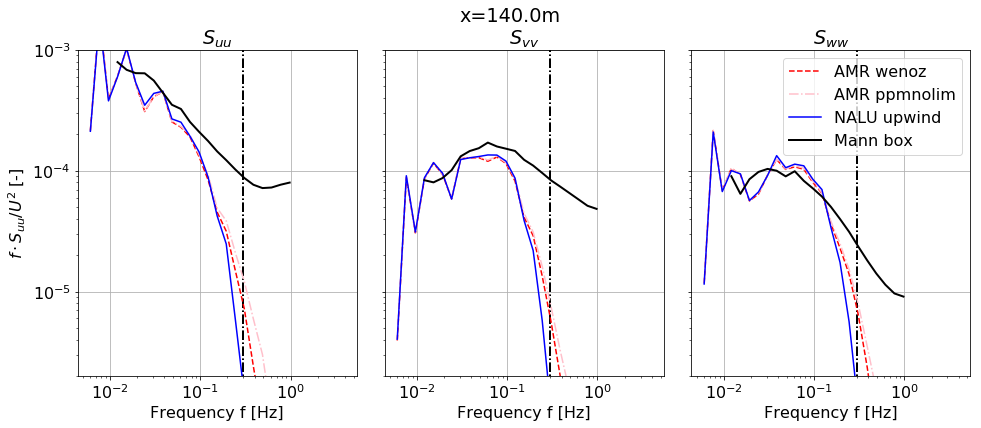

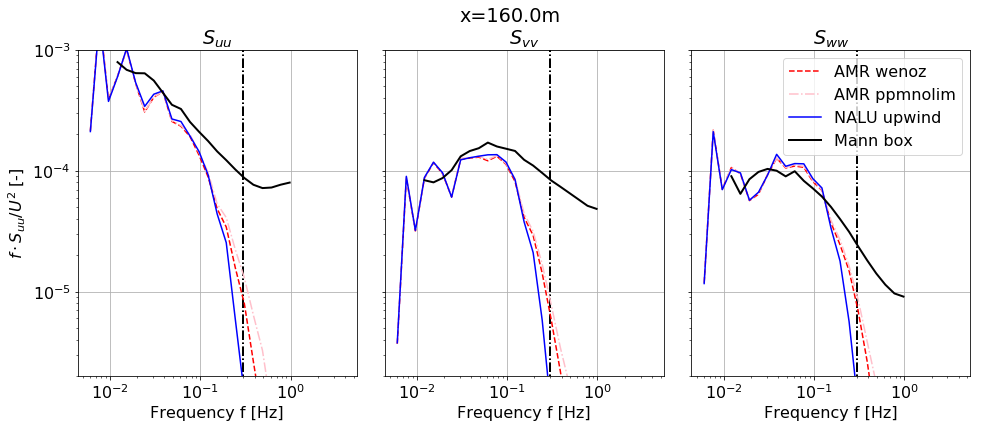

In [5]:
plt.rc('font', size=16)

deltaX= 2.5
fmax = 0.6*Uavg/(8*deltaX)

xlocations=np.linspace(-160, 160,17) #[-160, -140, -120, -100, -80, 160]

for ix, x in enumerate(xlocations):
    fig, axs = plt.subplots(1,3,figsize=(16,6),sharey=True)
    for case in cases:
        label = case[0]
        d     = case[1]
        dic   = case[2]
        fname   = d+'/spectra/spectra_%.2f.dat'%(x)
        spectra = np.loadtxt(fname)
        avgUlong= np.loadtxt(d+'/spectra/avgUlong.dat')
        avgU    = avgUlong[avgUlong[:,0]==x,1]
        #print(label+' '+repr(avgU))
        avgf    = spectra[:,0]
        avgSuu  = spectra[:,1]
        avgSvv  = spectra[:,2]
        avgSww  = spectra[:,3]
        color   = dic['color'] #colorcycle[ix]
        axs[0].loglog(avgf, avgf*avgSuu/avgU**2, ls=dic['ls'], color=color, label='%s'%(label))
        axs[1].loglog(avgf, avgf*avgSvv/avgU**2, ls=dic['ls'], color=color, label='%s'%(label))
        axs[2].loglog(avgf, avgf*avgSww/avgU**2, ls=dic['ls'], color=color, label='%s'%(label))

    axs[0].loglog(Mannf, Mannf*MannSuu/Uavg**2, 'k', lw=2, label='Mann box')
    axs[1].loglog(Mannf, Mannf*MannSvv/Uavg**2, 'k', lw=2, label='Mann box')
    axs[2].loglog(Mannf, Mannf*MannSww/Uavg**2, 'k', lw=2, label='Mann box')
    plt.ylim([2E-6, 1E-3])
    axs[2].legend()
    axs[0].set_title('$S_{uu}$')
    axs[1].set_title('$S_{vv}$')
    axs[2].set_title('$S_{ww}$')
    axs[0].set_ylabel('$f\cdot S_{uu}/U^2$ [-]')

    for i in range(3): 
        axs[i].vlines(fmax, 5e-11, 20,lw=2, linestyle='-.')
        axs[i].set_xlabel('Frequency f [Hz]')
        axs[i].grid()
    extratitle=' [Inlet]' if ix==0 else ''
    #fig.suptitle('1/3 Octave-band Avg spectra x={:.1f}m'.format(x))
    fig.suptitle('x={:.1f}m'.format(x)+extratitle)
    plt.subplots_adjust(wspace=0.1)